In [1]:
import os

def get_list_of_files(dir):
    #dir is a string
    path = dir
    list01 = os.listdir(path)
    for file in list01:
        if file[0] == '.':
            list01.remove(file)  #get rid of hidden files
    return list01

def parse_file_names(file_name):
    #name is a string
    parms_list = []
    new_name = file_name[0:-4]  #get rid of .log in file name 
    list_name = new_name.split('_')
    cycle = int(list_name[0][5:])  
    parms_list = list_name[1:]
    return parms_list, cycle  #parms_dict are the parameters of the test
        
def get_temp_data(fp, search_value):
    '''
    This function perfoms data parsing per cycle or one .log file at a time; 
    the data structure is a nested dict where:{module_number:{ambient_temp:XXC,...}}
    
    inputs:
    "line" is the string to perform search on where the string "temp" was pre-searched
    "cycle" is the log number
    "param_list" is the parameter to find the associated temperature 
    output: a nested dictionary where cycle # is the key followed by module # followed by
    time step ...
    '''
             
    output = {} #key: module number
       
    
    for line in fp:
        if search_value in line:  #search_value is user defined i.e.'temps:'
            date = line[0:15].strip()
            #print('date:',date)
            indx0 = line.find(']', 3)  #find indices to get module number
            indx1 = line.find(':', indx0+2)
            module = line[indx0+2:indx1].strip()
            if module not in output.keys():
                output[module] = {}
            #print('module:', module) #get the module number
            if 'time_stamp' not in output[module].keys():
                output[module]['time_stamp'] = [date]
            else:
                output[module]['time_stamp'].append(date)
            indx0 = line.find(search_value)  #search_value = 'temps:'
            indx1 = line.find(':', indx0)
            indx2 = line.find(':', indx1+1)

            
            while indx1 > 0 and indx2 > 0:
                name_of = line[indx1+1:indx2].strip()   # indx1 = : , indx2 = :
                #print('name_of:',name_of)
                indx1 = indx2  #indx2 = :
                indx2 = line.find('C', indx1)  #indx2 = C
                temp = float(line[indx1 + 1:indx2].strip())
                #print('temp:', temp)
                indx1 = indx2 + 1  #indx1 = ,
                indx2 = line.find(':', indx2) #indx2 = :
                
                if name_of not in output[module].keys():    
                    output[module][name_of] = [temp]
                else:
                    output[module][name_of].append(temp)
             
        else:
            continue
 
    return output
    
    
def make_master_dict(file_list, folder, search_value): 
    master_dict = {}
    unique_group_list = []
    for file in file_list:
        parms_list, key = parse_file_names(file) #key is cycle number
        #print(dict_parms, key) 
        with open(folder + file) as fp:
            new_dict = get_temp_data(fp, search_value)
            new_dict['parms'] = parms_list
            unique_group_list = determine_unique_groups(parms_list, unique_group_list)
            
            master_dict[key] = new_dict
    return master_dict, unique_group_list
            
def determine_unique_groups(parms_list, unique_group_list):
    if parms_list not in unique_group_list:
        unique_group_list.append(parms_list)
        return unique_group_list
    else:
        return unique_group_list
    

In [2]:

folder = '/Users/steve.su/OneDrive - ChargePoint/link_PB_logs/'
search_value = 'temps:'
file_list = get_list_of_files(folder)
print('file_list:', file_list)
master_dict, unique_group_list = make_master_dict(file_list, folder, search_value)
print('unique_group_list:', unique_group_list)
    

file_list: ['cycle89_busb_400v_475a.log', 'cycle21_busb_400v_475a.log', 'cycle46_busa_800v_240a.log', 'cycle32_busa_400v_475a.log', 'cycle178_busa_800v_240a.log', 'cycle55_busb_800v_240a.log', 'cycle115_busb_800v_240a.log', 'cycle38_busa_800v_240a.log', 'cycle172_busa_400v_475a.log', 'cycle90_busa_800v_240a.log', 'cycle106_busa_800v_240a.log', 'cycle1_busb_400v_475a.log', 'cycle161_busb_400v_475a.log', 'cycle83_busb_800v_240a.log', 'cycle200_busa_400v_475a.log', 'cycle75_busb_800v_240a.log', 'cycle197_busb_400v_475a.log', 'cycle12_busa_400v_475a.log', 'cycle158_busa_800v_240a.log', 'cycle66_busa_800v_240a.log', 'cycle184_busa_400v_475a.log', 'cycle141_busb_400v_475a.log', 'cycle126_busa_800v_240a.log', 'cycle18_busa_800v_240a.log', 'cycle152_busa_400v_475a.log', 'cycle135_busb_800v_240a.log', 'cycle132_busa_400v_475a.log', 'cycle78_busa_800v_240a.log', 'cycle155_busb_800v_240a.log', 'cycle121_busb_400v_475a.log', 'cycle189_busb_400v_475a.log', 'cycle146_busa_800v_240a.log', 'cycle183_b

In [3]:

def combine_cycle_data(master_dict, unique_group_list):
    group_dict = {}  #{('busb', '400v', '475a'):{module01:{'ambient':[]}}, ('busb','800v','240a'):{module01:{}}}
    cycle_ordered = list(master_dict.keys())
    cycle_ordered = sorted(cycle_ordered)
    #print('cycle_ordered:', cycle_ordered)
    group_dict = {}
    for some_list in unique_group_list:
        group_dict[tuple(some_list)] = {}  #key must be immutable and thus the list was coerced to tuple
     
    #sub_group = {}  #{'module01':{'ambient':[x,y,z],'cap_max':[a,b,c]}, 'module02': {'ambient': [x,y,z], ...}, ...}

    for cycle_key in cycle_ordered:
        #print('cycle_key:', cycle_key)
        module_keys = master_dict[cycle_key].keys()  #i.e. secondary keys are module #s
        module_keys = list(module_keys)[ :-1]  #why -1? to remove 'parms' key
        #print('module_keys:', module_keys)
        group_key = tuple(master_dict[cycle_key]['parms']) 

        group_dict = some_func(master_dict, cycle_key, group_key, module_keys, group_dict)    
        

    return group_dict

def some_func(master_dict, cycle_key, group_key, module_keys, group_dict):
    #print('group_dict:', group_dict)
    #get all the module #s
    #sub_dict = {} #{'module01':{'ambient':[x,y,z],'cap_max':[a,b,c]}, 'module02': {'ambient': [x,y,z], ...}, ...}
    for mod_key in module_keys:
        #print('mod_key:', mod_key)
        #print('group_dict[group_key]:', group_dict[group_key])
        if mod_key not in group_dict[group_key].keys():
            group_dict[group_key][mod_key] = {}  
            
            #get temperatures ie ambient, capacitor_max, ...
        for temp_key in master_dict[cycle_key][mod_key].keys():
            #print(temp_key)
            if temp_key not in group_dict[group_key][mod_key].keys():
                group_dict[group_key][mod_key][temp_key] = []
                
            group_dict[group_key][mod_key][temp_key] = group_dict[group_key][mod_key][temp_key] + master_dict[cycle_key][mod_key][temp_key]
                
    return group_dict

In [4]:
def map_to_group(unique_group_list):
    output = {}
    for indx, group in enumerate(unique_group_list):
        output[indx] = tuple(group)
    return output

In [5]:
combined_cycles_dict = combine_cycle_data(master_dict, unique_group_list)


In [6]:
group_map = map_to_group(unique_group_list)
group_map
    

{0: ('busb', '400v', '475a'),
 1: ('busa', '800v', '240a'),
 2: ('busa', '400v', '475a'),
 3: ('busb', '800v', '240a')}

In [7]:
#enter group choice from above as integer
group_choice = 0
modules_available = sorted(list(combined_cycles_dict[group_map[group_choice]].keys()))
modules_available

['011', '012', '014', '015', '016']

In [8]:
#enter module choice from above with single quotes
module_choice = '011'


In [42]:
import pandas as pd

df = pd.DataFrame(combined_cycles_dict[group_map[group_choice]][module_choice])
df

,time_stamp,ambient,capacitor_max,dclink_capacitor_1,dclink_capacitor_2,llc_magnetic_assembly_1,llc_magnetic_assembly_2,llc_module_1,llc_module_2,magnetic_assembly_max,module_max,output_capacitor,pfc_boost_inductor,pfc_module_l1_l2,pfc_module_l2_l3,rectifier_module
0,Jun 01 02:19:47,65.0,68.0,68.02,-40.0,73.38,83.69,25.0,25.0,84.0,61.0,25.0,67.66,25.00,25.00,61.26
1,Jun 01 02:22:55,65.0,68.0,68.37,-40.0,78.75,84.87,25.0,25.0,85.0,66.0,25.0,71.94,59.01,57.87,65.56
2,Jun 01 02:32:55,70.0,71.0,71.12,-40.0,87.79,98.69,25.0,25.0,99.0,71.0,25.0,82.03,63.00,62.19,70.74
3,Jun 01 04:48:37,72.0,81.0,80.86,-40.0,83.46,100.47,25.0,25.0,100.0,62.0,25.0,73.97,25.00,25.00,68.23
4,Jun 01 04:49:25,71.0,81.0,80.72,-40.0,83.56,99.13,25.0,25.0,99.0,67.0,25.0,74.29,59.01,58.32,66.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Jun 06 12:54:03,76.0,86.0,86.44,-40.0,86.96,99.30,25.0,25.0,99.0,74.0,25.0,81.36,67.09,65.85,74.28
127,Jun 06 13:02:03,79.0,86.0,85.90,-40.0,95.92,106.09,25.0,25.0,106.0,79.0,25.0,90.25,71.21,69.90,78.57
128,Jun 06 15:22:04,77.0,86.0,85.88,-40.0,85.72,99.72,25.0,25.0,100.0,69.0,25.0,79.82,25.00,25.00,68.72
129,Jun 06 15:23:04,75.0,86.0,85.66,-40.0,86.12,98.39,25.0,25.0,98.0,74.0,25.0,80.78,66.38,65.35,73.64


In [43]:
df.columns

Index(['time_stamp', 'ambient', 'capacitor_max', 'dclink_capacitor_1',
       'dclink_capacitor_2', 'llc_magnetic_assembly_1',
       'llc_magnetic_assembly_2', 'llc_module_1', 'llc_module_2',
       'magnetic_assembly_max', 'module_max', 'output_capacitor',
       'pfc_boost_inductor', 'pfc_module_l1_l2', 'pfc_module_l2_l3',
       'rectifier_module'],
      dtype='object')

Text(0.5, 1.0, "('busb', '400v', '475a') module: 011")

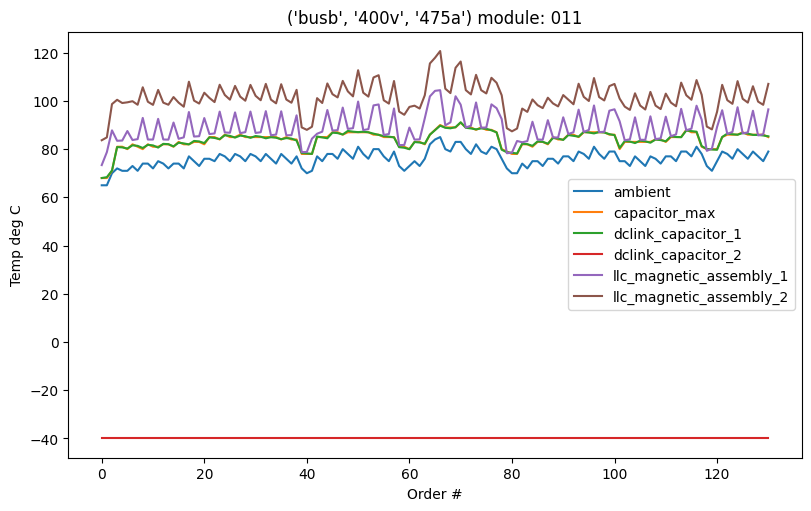

In [52]:
list_of = ['ambient', 'capacitor_max', 'dclink_capacitor_1','dclink_capacitor_2']
list_of = df.columns[1:7]
import matplotlib
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (8, 5),layout = 'constrained')  # Create a figure containing a single axes

for i in range(len(list_of)):
        data_temps = df[list_of[i]]
        ax.plot(data_temps, label = list_of[i])
        ax.legend()    
        #ax.set_ylim(0, 90)
ax.set_xlabel('Order #')  # Add an x-label to the axes.
ax.set_ylabel('Temp deg C')  # Add a y-label to the axes.
ax.set_title(str(group_map[group_choice]) + ' ' + 'module: ' + str(module_choice))